<a href="https://colab.research.google.com/github/sdlt2003/lain-bootleg-bootleg-to-NDS/blob/master/HB_NSGA_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from itertools import combinations

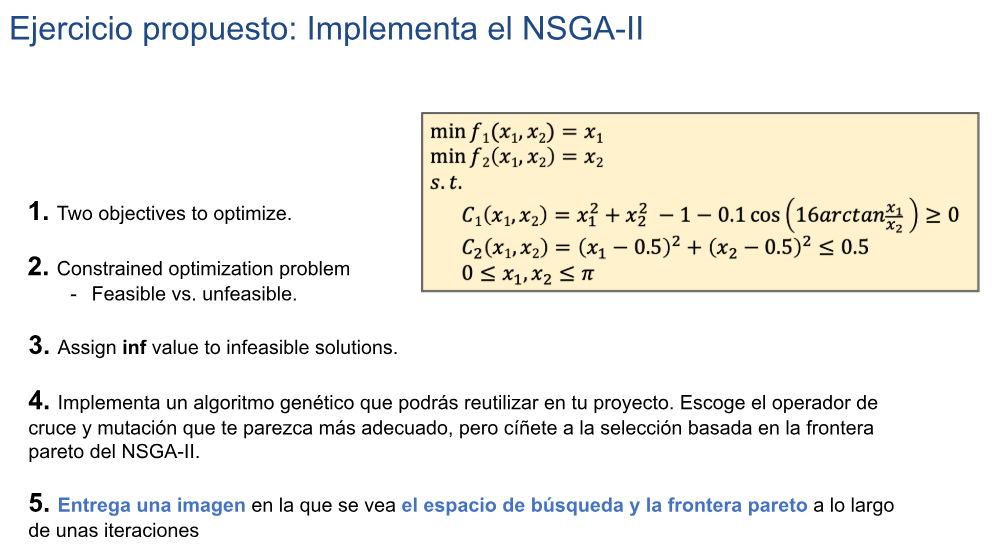

# 1. Inicialización del problema

In [ ]:

def evaluar_problema_binh_korn(x):
    x1, x2 = x[0], x[1]
    objetivos = [x1, x2] # Objetivos a minimizar
    termino_coseno = 0.1 * np.cos(16 * np.arctan2(x1, x2))
    g1 = -(x1**2 + x2**2 - 1 - termino_coseno)
    g2 = (x1 - 0.5)**2 + (x2 - 0.5)**2 - 0.5
    restricciones = [g1, g2]
    return objetivos, restricciones

def es_factible(x):
    _, restricciones = evaluar_problema_binh_korn(x)
    return all(g <= 0 for g in restricciones)

def generar_poblacion_inicial(n_poblacion, limites_inf, limites_sup):
    poblacion = []
    dimension = len(limites_inf)
    print(f"Generando población inicial de {n_poblacion} individuos factibles...")
    intentos = 0
    while len(poblacion) < n_poblacion:
        intentos += 1
        candidato = np.random.uniform(low=limites_inf, high=limites_sup, size=dimension)
        if es_factible(candidato):
            poblacion.append(candidato)
    print(f"Población generada con {intentos} intentos.")
    return np.array(poblacion)

def evaluar_poblacion(poblacion):
    return np.array([evaluar_problema_binh_korn(ind)[0] for ind in poblacion])

# 2. Dominancia y fronteras pareto

In [ ]:

def domina(obj_a, obj_b):
    """Comprueba si la solución 'a' domina a la solución 'b'."""
    if obj_a[0] <= obj_b[0] and obj_a[1] <= obj_b[1]:
        if obj_a[0] < obj_b[0] or obj_a[1] < obj_b[1]:
            return True
    return False

def encontrar_frontera(poblacion, objetivos):
    """Encuentra el primer frente de Pareto de una población."""
    indices_frontera = []
    for i in range(len(poblacion)):
        es_dominado = False
        for j in range(len(poblacion)):
            if i == j:
                continue
            # Comparamos usando los objetivos ya calculados
            if domina(objetivos[j], objetivos[i]):
                es_dominado = True
                break
        if not es_dominado:
            indices_frontera.append(i)
    return poblacion[indices_frontera], objetivos[indices_frontera]


# 3. Operadores genéticos

In [ ]:

# --- Operadores Genéticos (Cruce y Mutación) ---

def cruce_sbx(p1, p2, eta, lim_inf, lim_sup):
    """Simulated Binary Crossover (SBX)."""
    h1, h2 = p1.copy(), p2.copy()
    for i in range(len(p1)):
        if np.random.rand() > 0.5: # 50% de probabilidad de cruzar cada variable
            continue

        u = np.random.rand()
        if u <= 0.5:
            beta = (2 * u)**(1 / (eta + 1))
        else:
            beta = (1 / (2 * (1 - u)))**(1 / (eta + 1))

        h1[i] = 0.5 * ((1 + beta) * p1[i] + (1 - beta) * p2[i])
        h2[i] = 0.5 * ((1 - beta) * p1[i] + (1 + beta) * p2[i])

    # Asegurar que los hijos están dentro de los límites
    h1 = np.clip(h1, lim_inf, lim_sup)
    h2 = np.clip(h2, lim_inf, lim_sup)
    return h1, h2

def mutacion_polinomial(ind, eta, lim_inf, lim_sup):
    """Polynomial Mutation."""
    mutado = ind.copy()
    for i in range(len(ind)):
        if np.random.rand() < (1.0 / len(ind)): # Probabilidad de mutar cada variable
            u = np.random.rand()
            if u < 0.5:
                delta = (2 * u)**(1 / (eta + 1)) - 1
            else:
                delta = 1 - (2 * (1 - u))**(1 / (eta + 1))

            mutado[i] += delta * (lim_sup[i] - lim_inf[i])

    # Asegurar que el mutado está dentro de los límites
    mutado = np.clip(mutado, lim_inf, lim_sup)
    return mutado

# 4. Función para plottear

In [ ]:
def plotear_generacion(poblacion, frontera, titulo, esp_factible, limites):
    plt.clf()
    plt.imshow(esp_factible, extent=limites, origin='lower', cmap='Greens', alpha=0.3)

    # Dibujar toda la población en gris
    plt.scatter(poblacion[:, 0], poblacion[:, 1], c='gray', s=20, alpha=0.7, label='Población')
    # Resaltar la frontera en rojo
    plt.scatter(frontera[:, 0], frontera[:, 1], c='red', s=40, edgecolors='black', label='Frontera de Pareto')

    plt.title(titulo, fontsize=16)
    plt.xlabel('x1 (Objetivo 1)', fontsize=12)
    plt.ylabel('x2 (Objetivo 2)', fontsize=12)
    plt.xlim(limites[0] - 0.1, limites[1] + 0.1)
    plt.ylim(limites[2] - 0.1, limites[3] + 0.1)
    plt.axis('equal')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.pause(0.1)


# 5. Hiperparámetros


In [ ]:
# --- Parámetros del Algoritmo ---
N_POBLACION = 100
LIMITES_INFERIORES = [0, 0]
LIMITES_SUPERIORES = [1.5, 1.5]
N_GENERACIONES = 50
ETA_CRUCE = 15       # Parámetro para SBX
ETA_MUTACION = 20    # Parámetro para Mutación Polinomial

# --- 1. Preparación (Cálculos de una sola vez) ---
print("Calculando el espacio factible para el fondo del gráfico...")
n_grid = 300
x_vals = np.linspace(LIMITES_INFERIORES[0], LIMITES_SUPERIORES[0], n_grid)
y_vals = np.linspace(LIMITES_INFERIORES[1], LIMITES_SUPERIORES[1], n_grid)
X, Y = np.meshgrid(x_vals, y_vals)
espacio_factible_matriz = np.array([es_factible([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
limites_grafico = [LIMITES_INFERIORES[0], LIMITES_SUPERIORES[0], LIMITES_INFERIORES[1], LIMITES_SUPERIORES[1]]


Calculando el espacio factible para el fondo del gráfico...


# 6. Código principal


Generando población inicial de 100 individuos factibles...
Población generada con 433 intentos.

--- Iniciando el Algoritmo Evolutivo ---


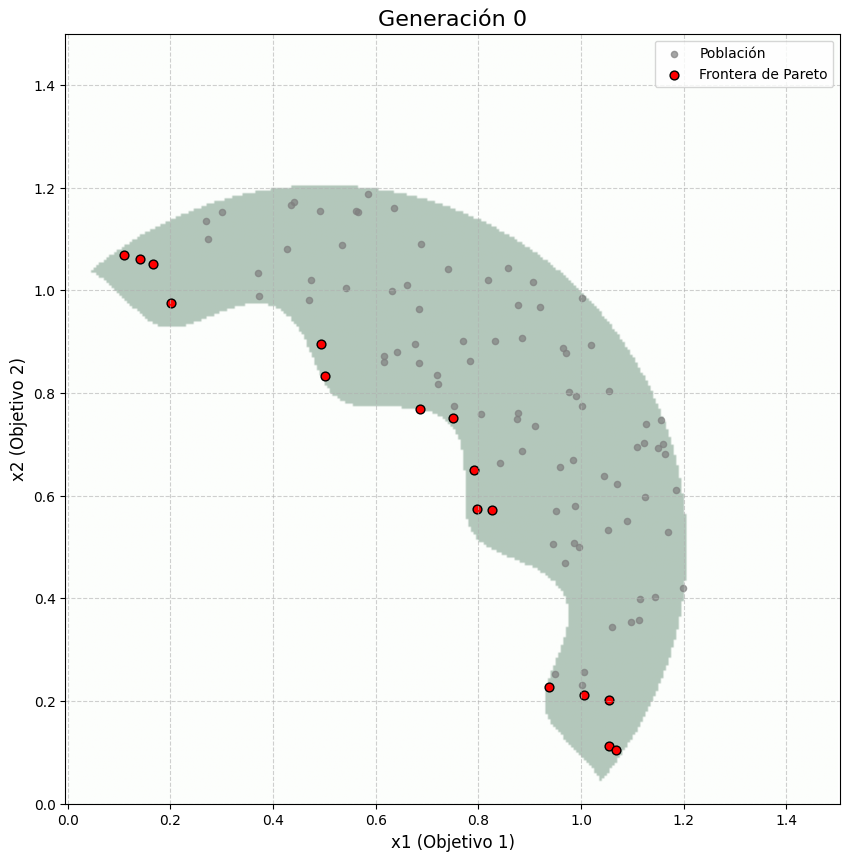

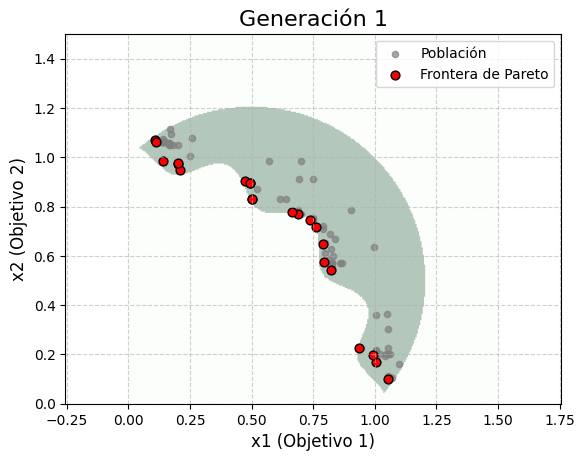

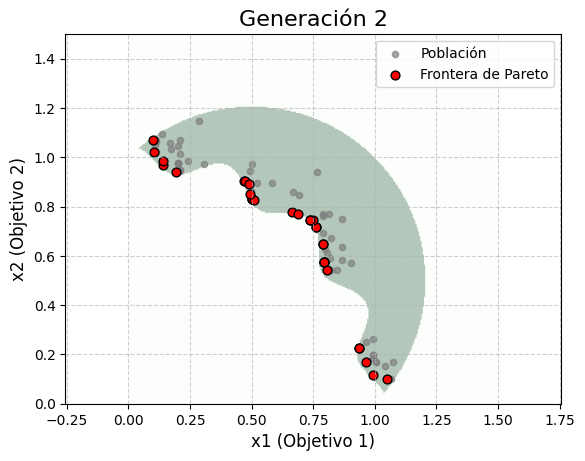

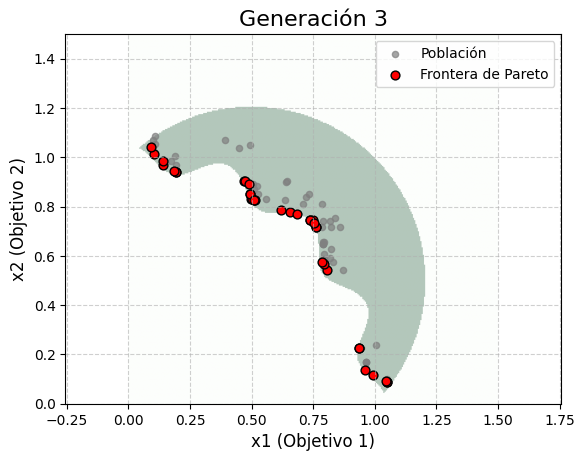

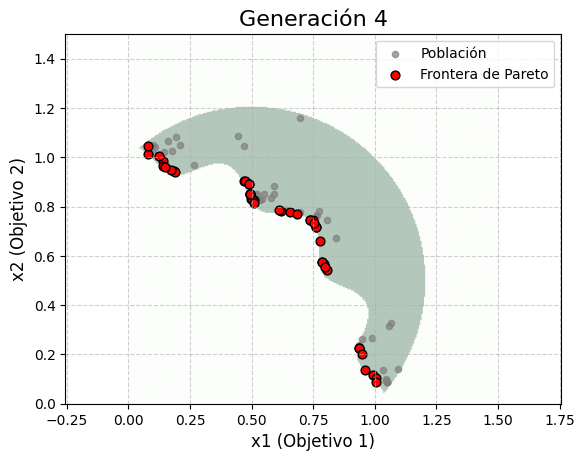

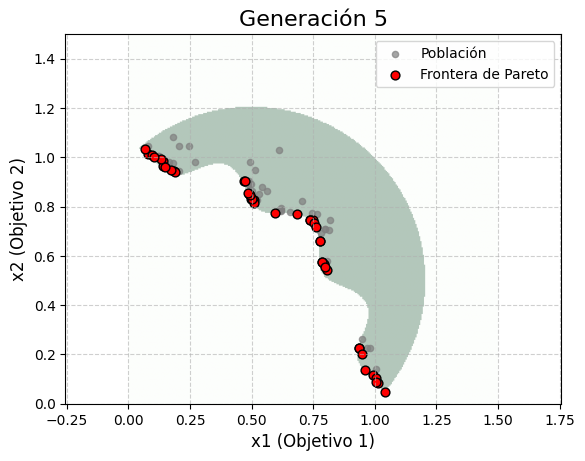

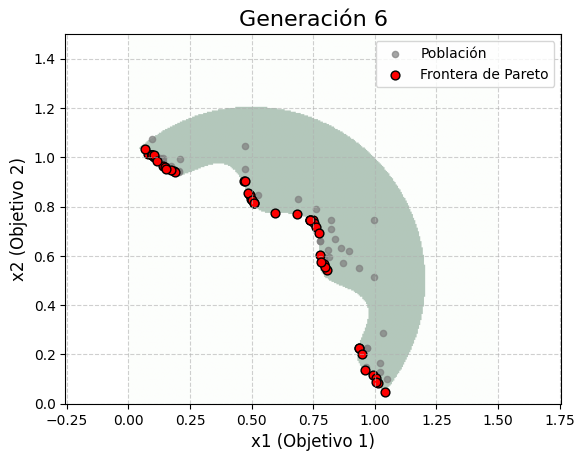

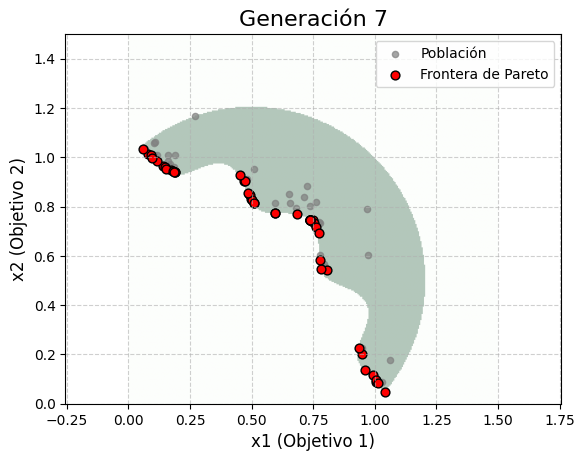

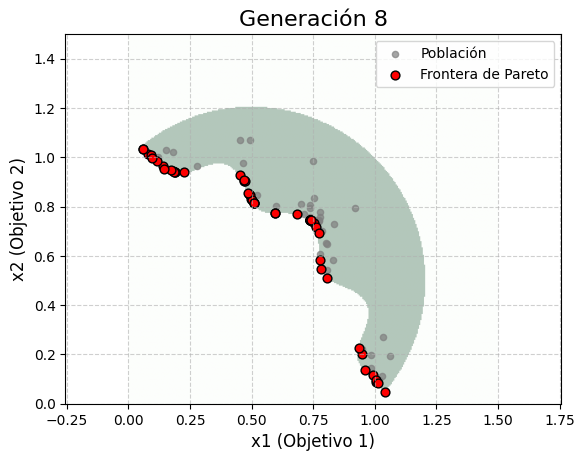

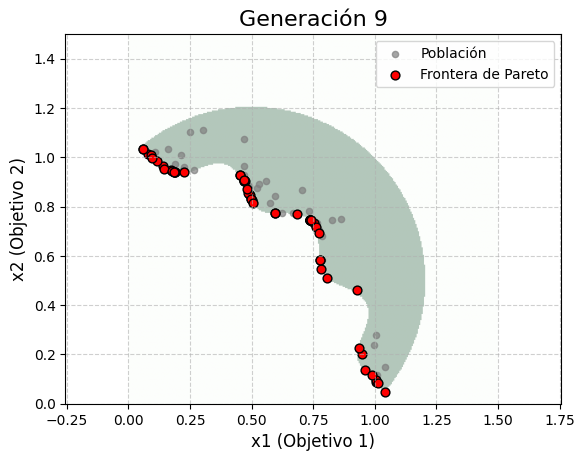

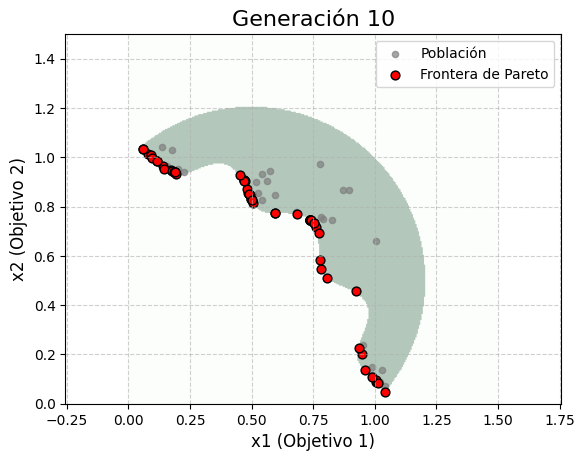

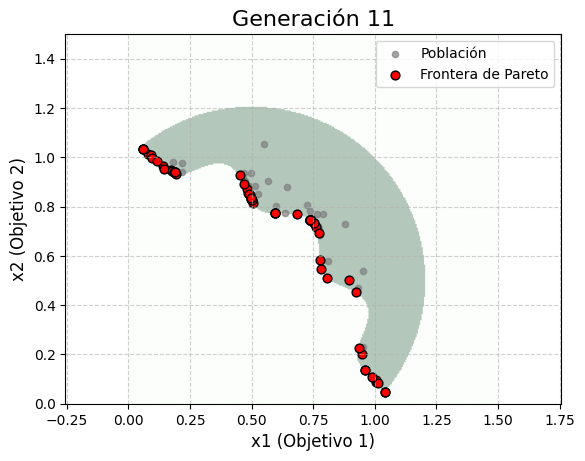

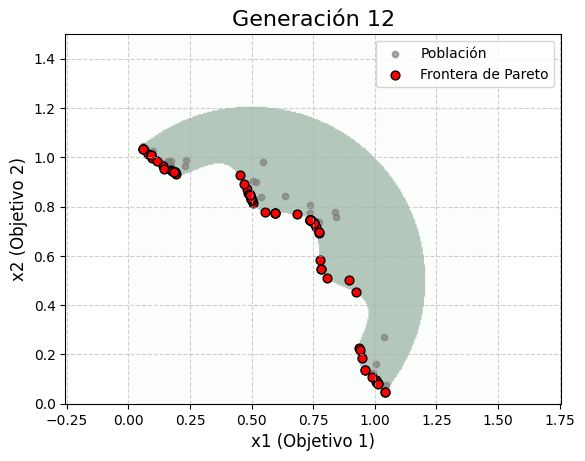

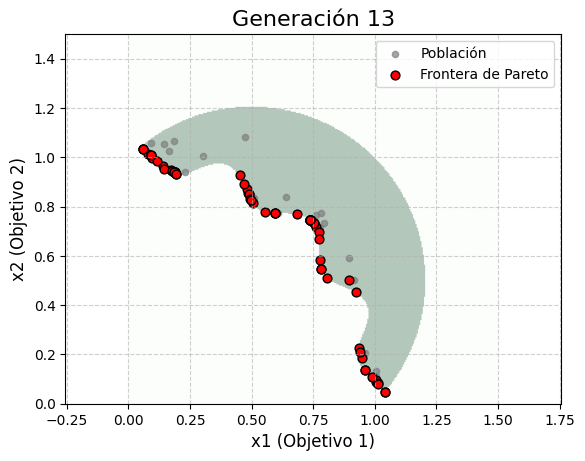

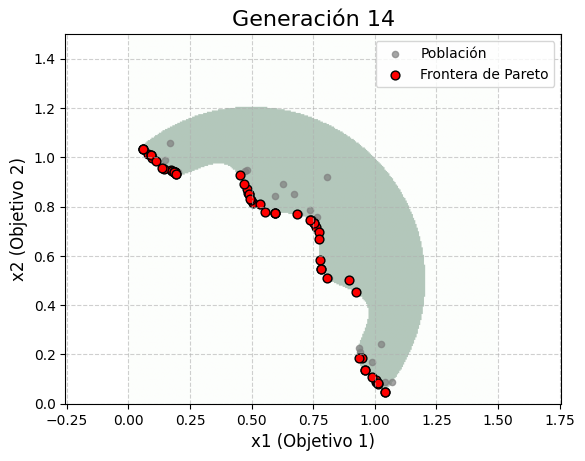

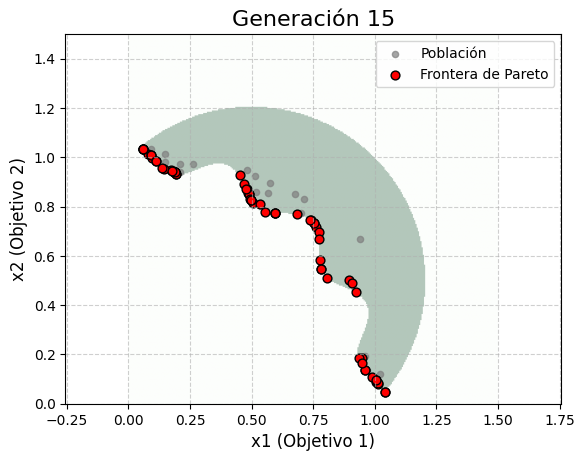

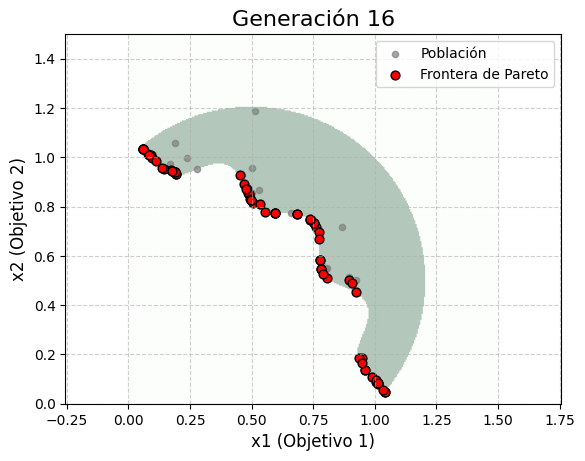

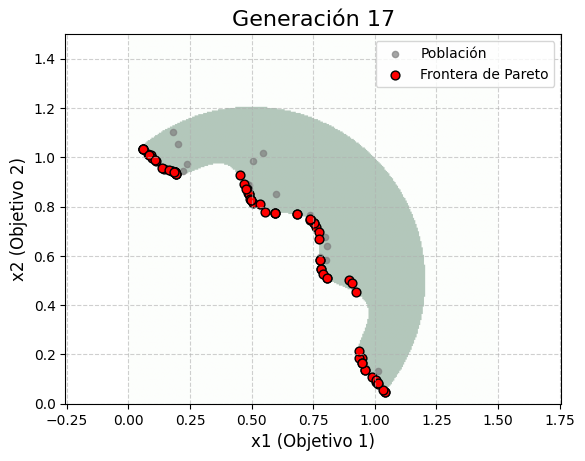

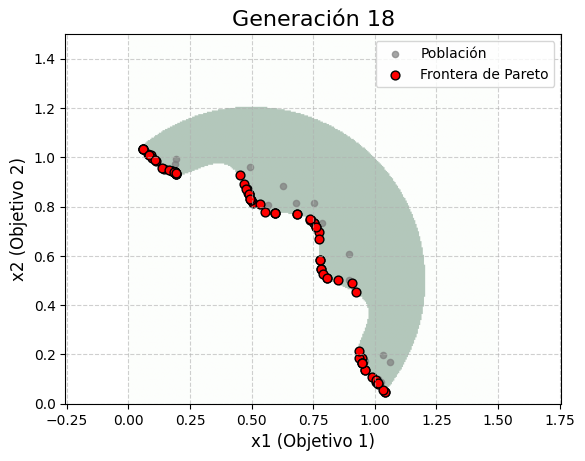

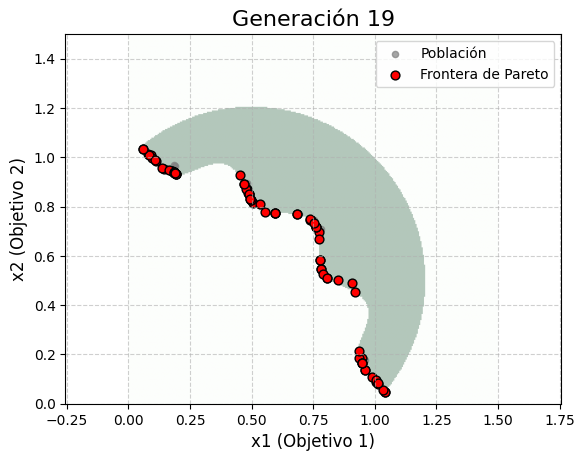

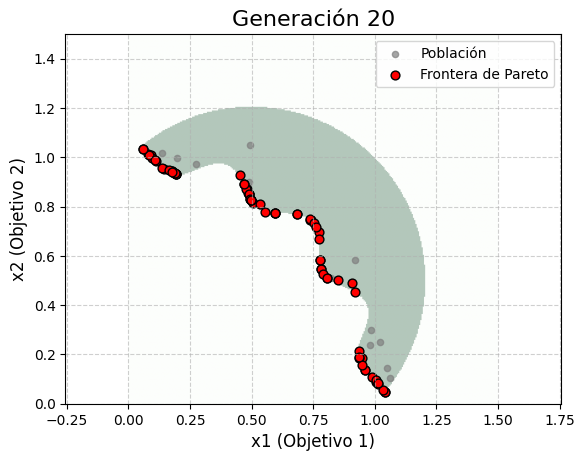

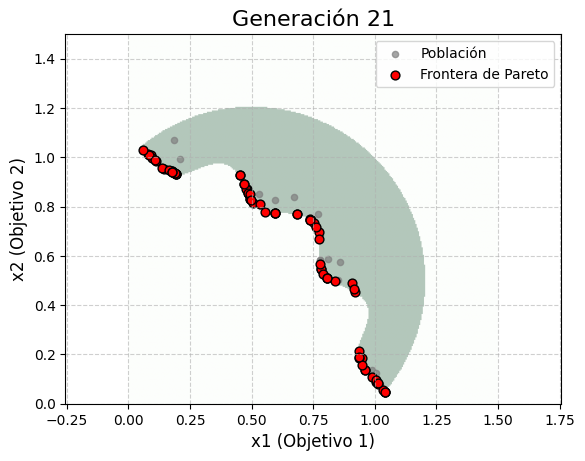

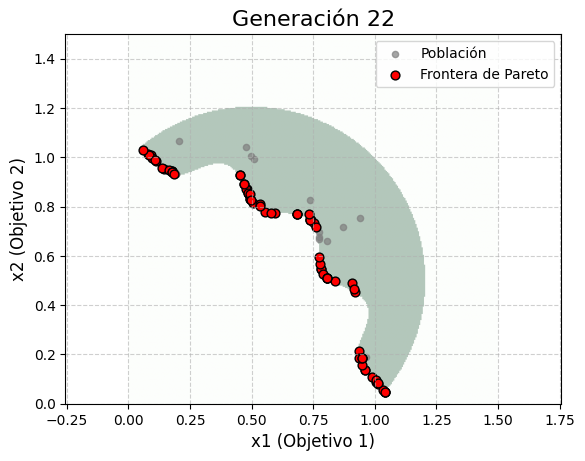

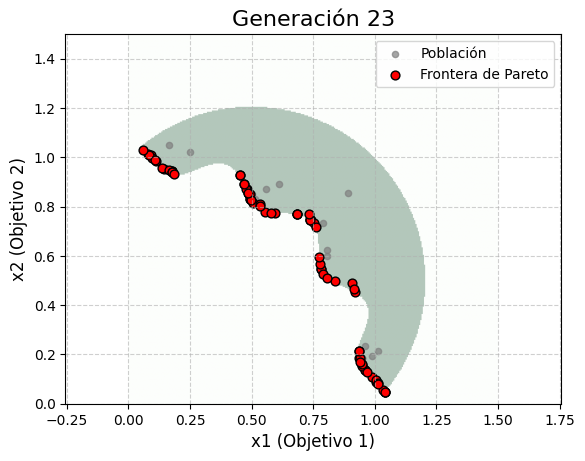

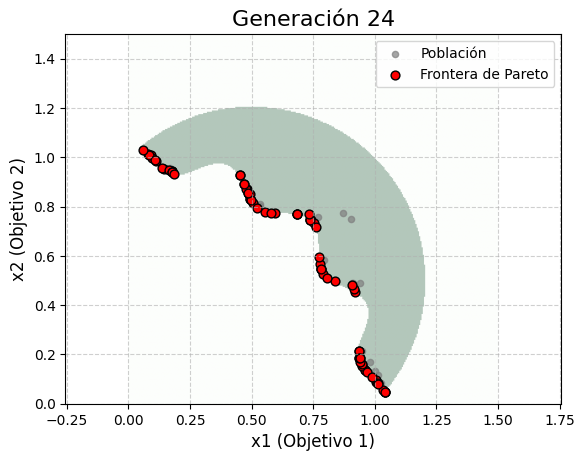

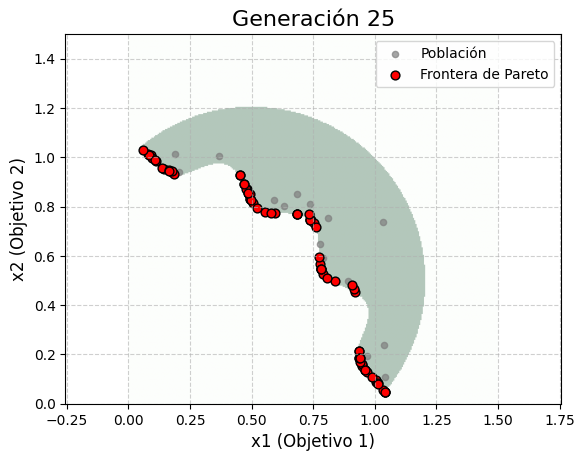

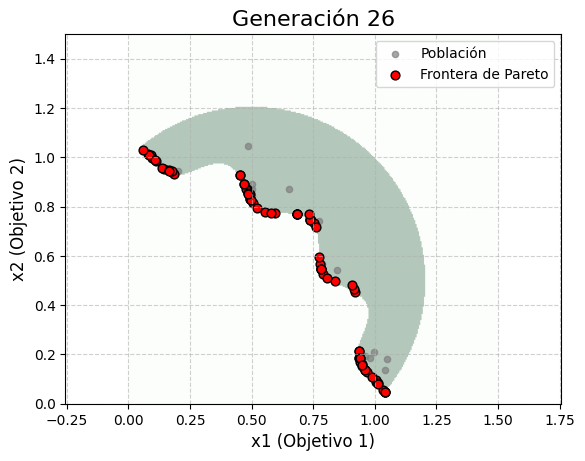

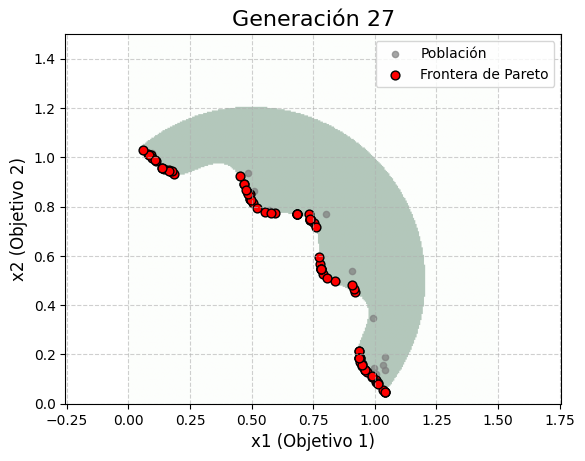

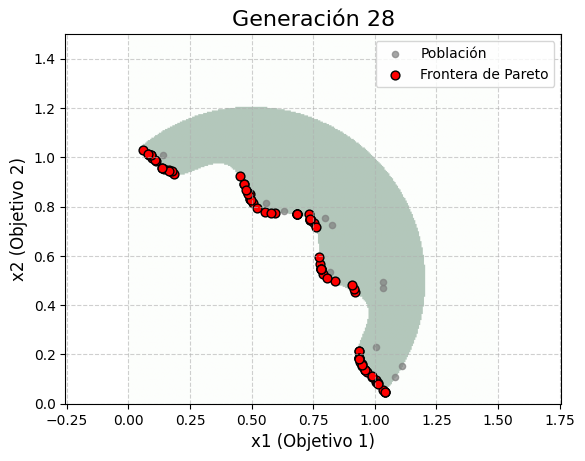

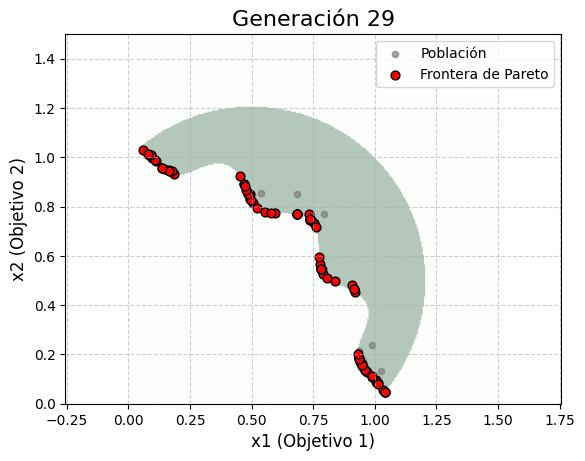

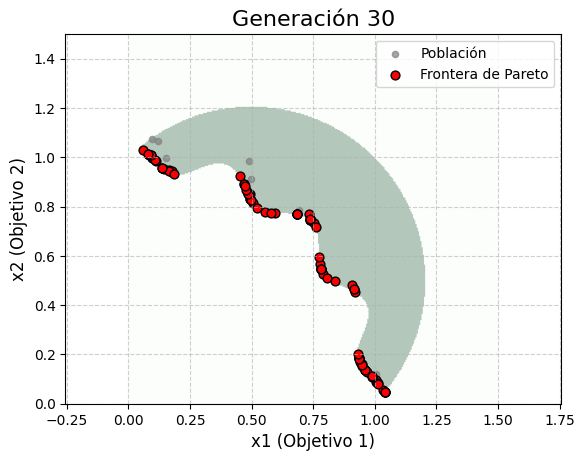

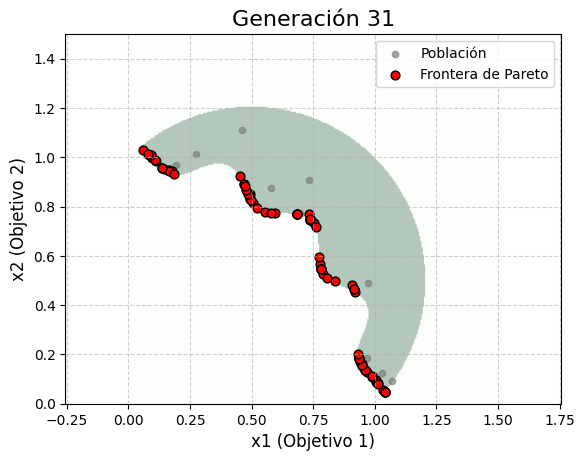

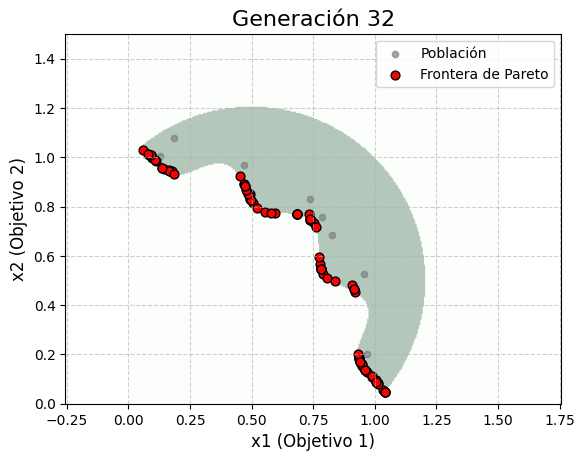

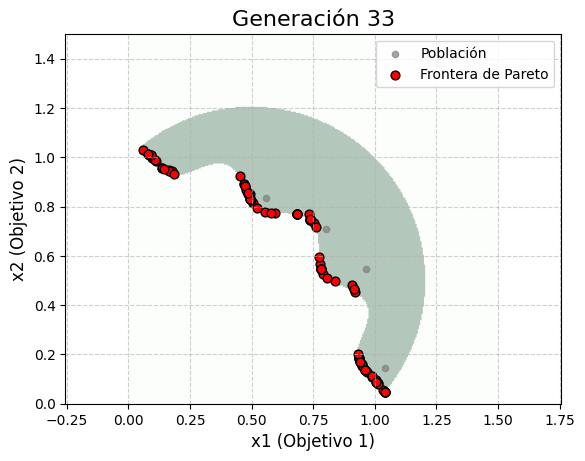

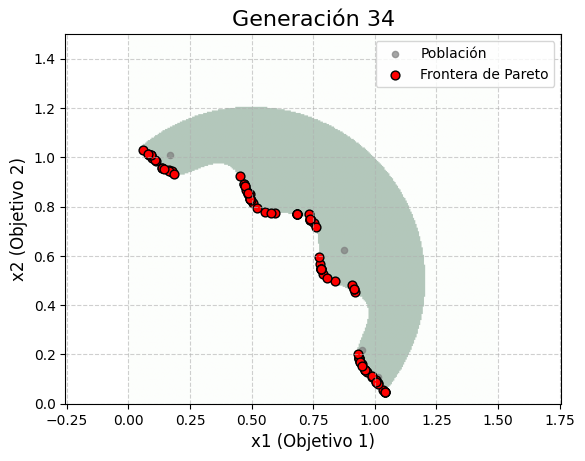

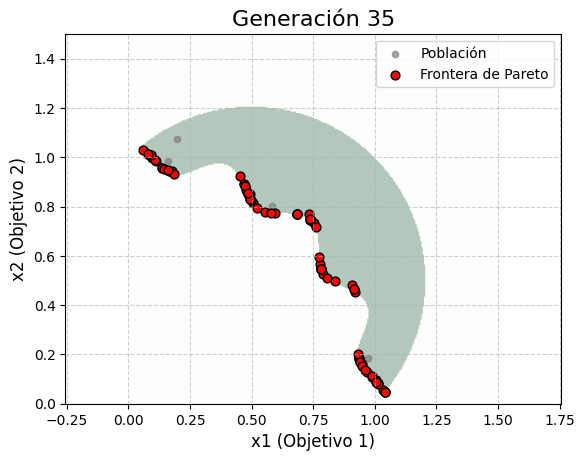

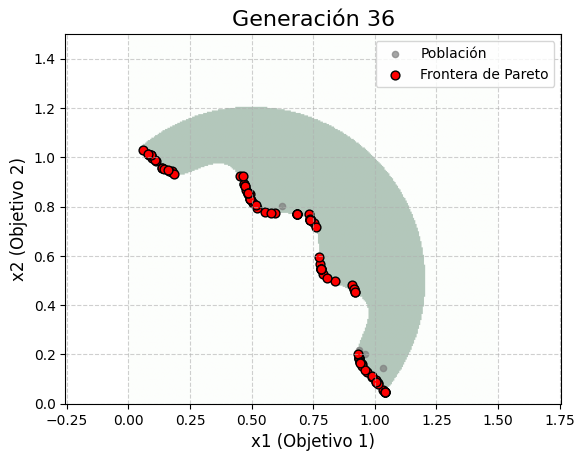

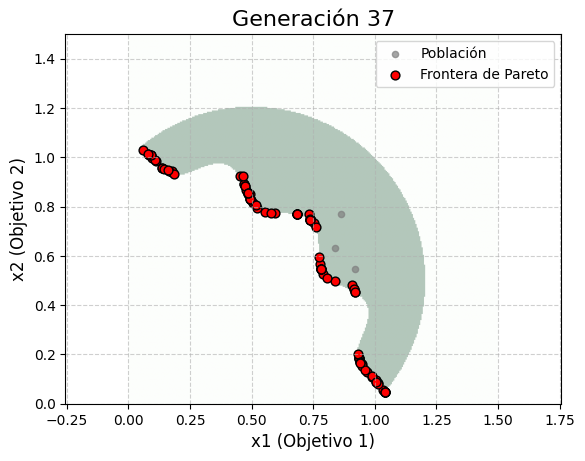

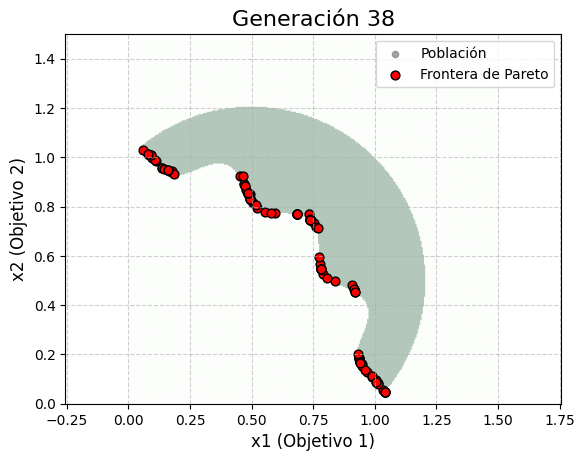

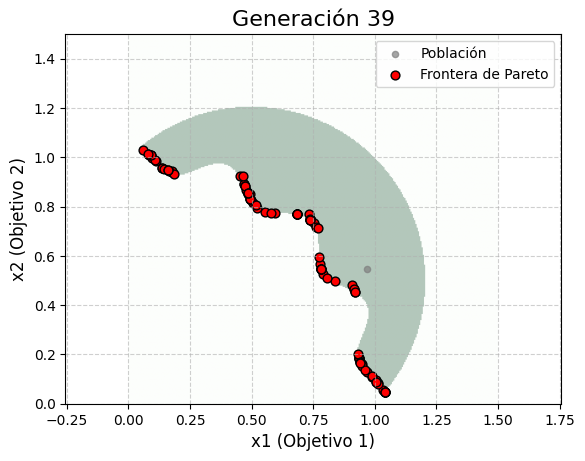

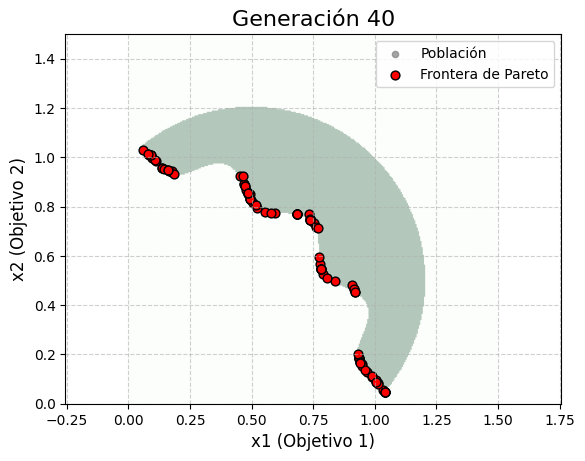

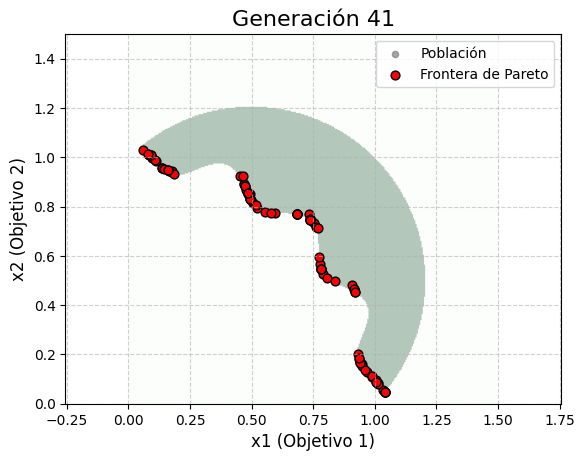

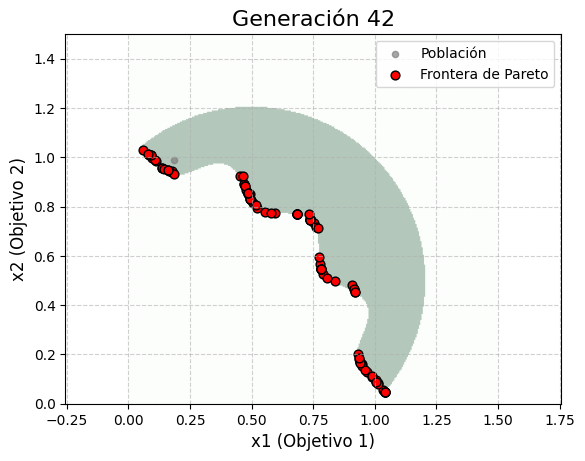

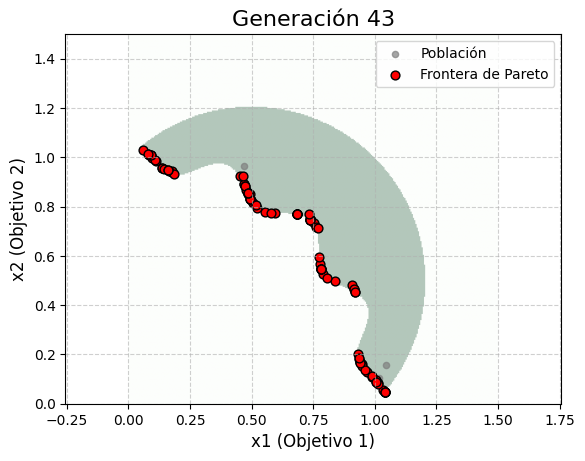

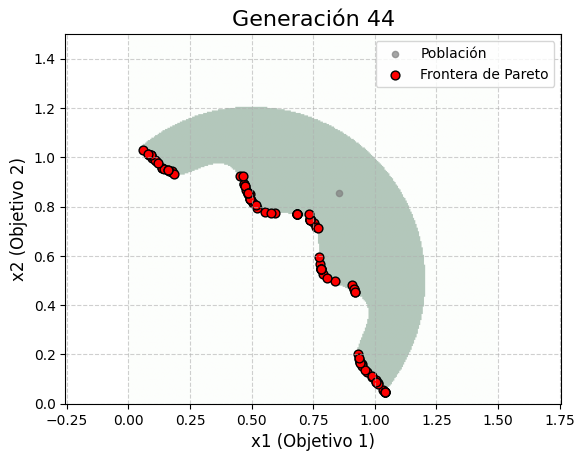

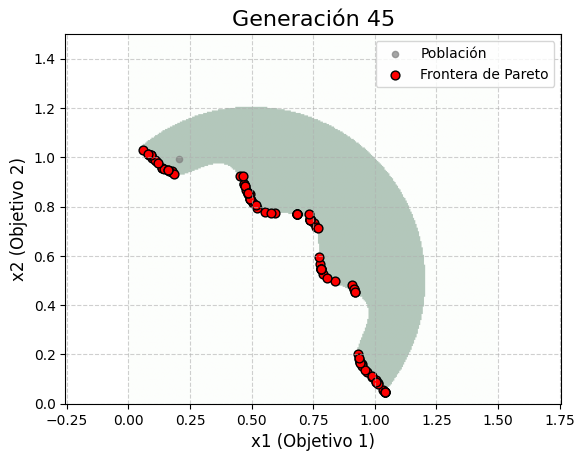

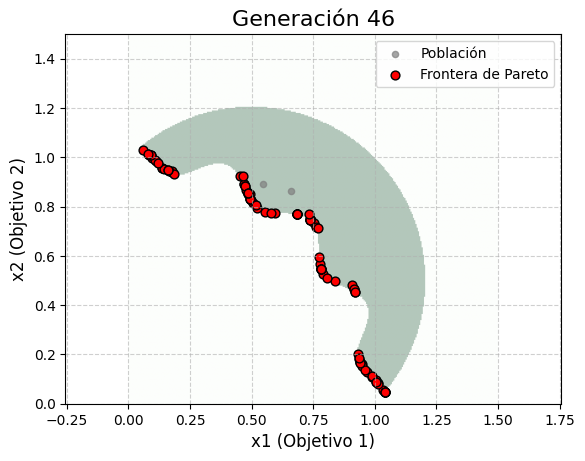

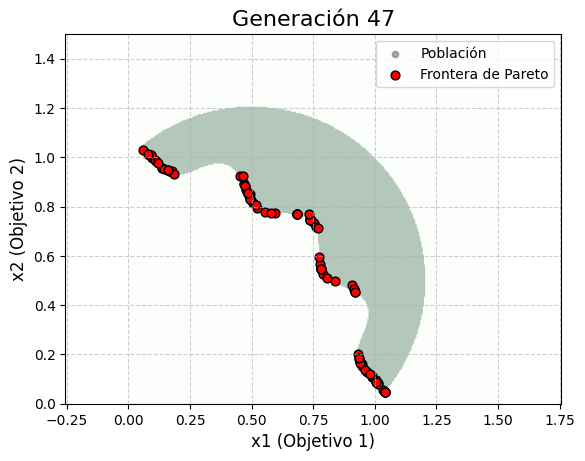

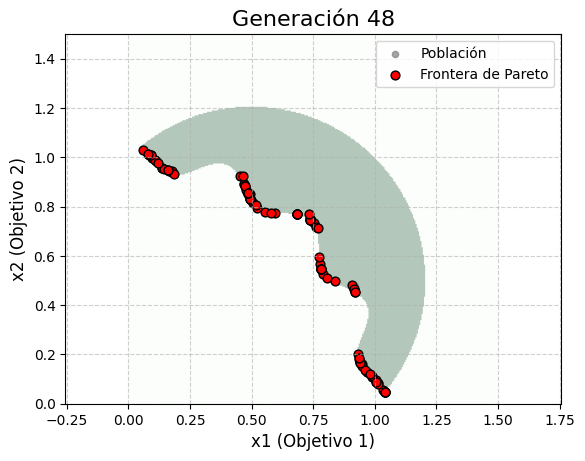

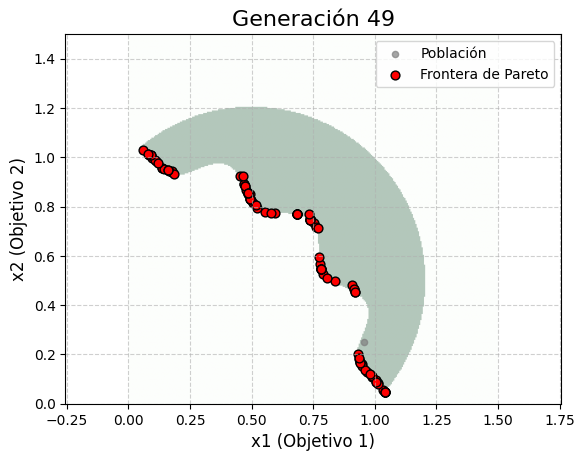

--- Algoritmo Finalizado ---


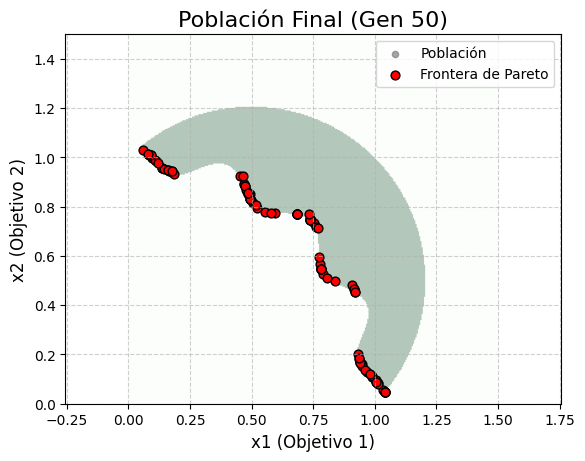

In [ ]:

poblacion_actual = generar_poblacion_inicial(N_POBLACION, LIMITES_INFERIORES, LIMITES_SUPERIORES)

plt.ion()
fig = plt.figure(figsize=(10, 10))

# --- 3. Bucle Evolutivo Principal ---
print("\n--- Iniciando el Algoritmo Evolutivo ---")
for i in range(N_GENERACIONES):

    # 1. EVALUAR la población actual
    objetivos_actuales = evaluar_poblacion(poblacion_actual)

    # 2. ENCONTRAR la frontera (elitismo)
    frente_actual, _ = encontrar_frontera(poblacion_actual, objetivos_actuales)

    # 3. VISUALIZAR el estado actual
    plotear_generacion(poblacion_actual, frente_actual, f"Generación {i}", espacio_factible_matriz, limites_grafico)

    # 4. CREAR la siguiente generación
    poblacion_siguiente = []
    # Elitismo: La frontera actual pasa directamente a la siguiente generación
    poblacion_siguiente.extend(list(frente_actual))

    # Rellenar el resto de la población con hijos
    while len(poblacion_siguiente) < N_POBLACION:
        # Selección por torneo de 2 padres desde la frontera
        idx1, idx2 = np.random.choice(len(frente_actual), 2, replace=False)
        padre1, padre2 = frente_actual[idx1], frente_actual[idx2]

        # Cruce
        hijo1, hijo2 = cruce_sbx(padre1, padre2, ETA_CRUCE, LIMITES_INFERIORES, LIMITES_SUPERIORES)

        # Mutación
        hijo1 = mutacion_polinomial(hijo1, ETA_MUTACION, LIMITES_INFERIORES, LIMITES_SUPERIORES)
        hijo2 = mutacion_polinomial(hijo2, ETA_MUTACION, LIMITES_INFERIORES, LIMITES_SUPERIORES)

        # Añadir a la población SÓLO si son factibles
        if es_factible(hijo1):
            poblacion_siguiente.append(hijo1)
        if len(poblacion_siguiente) < N_POBLACION and es_factible(hijo2):
            poblacion_siguiente.append(hijo2)

    poblacion_actual = np.array(poblacion_siguiente)

# --- 4. Finalización ---
print("--- Algoritmo Finalizado ---")
# Evaluar y encontrar la frontera final para la última visualización
objetivos_finales = evaluar_poblacion(poblacion_actual)
frontera_final, _ = encontrar_frontera(poblacion_actual, objetivos_finales)
plotear_generacion(poblacion_actual, frontera_final, f"Población Final (Gen {N_GENERACIONES})", espacio_factible_matriz, limites_grafico)

plt.ioff()
plt.show()